In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import robust_loss_pytorch.general

# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask1 = np.random.uniform(size=n) > 0.9
flip_mask2 = np.random.uniform(size=n) <0.1
y = np.where(flip_mask1, 1*np.random.uniform(size=n), y)
y = np.where(flip_mask2, -1*np.random.uniform(size=n), y)

x = torch.Tensor(x)
y = torch.Tensor(y)


class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]

def plot_regression(regression):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true

    plt.figure(0, figsize=(4,4))
    plt.scatter(x, y)
    plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='r')
    plt.legend(['true','learned'],loc='upper left')
    

0   : loss=59.279018
100 : loss=7.002073
200 : loss=6.710061
300 : loss=6.625587
400 : loss=6.584109
500 : loss=6.567844
600 : loss=6.562624
700 : loss=6.561238
800 : loss=6.560933
900 : loss=6.560876
1000: loss=6.560868
1100: loss=6.560867
1200: loss=6.560867
1300: loss=6.560867
1400: loss=6.560867
1500: loss=6.560867
1600: loss=6.560867
1700: loss=6.560867
1800: loss=6.560867
1900: loss=6.560867


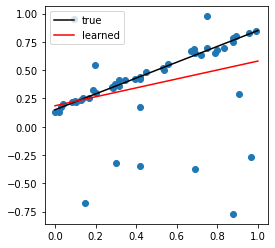

In [2]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 
loss_MSE=[]
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    loss_MSE.append(loss)
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression)

In [3]:
print(list(regression.parameters()))

[Parameter containing:
tensor([[0.3952]], requires_grad=True), Parameter containing:
tensor([0.1853], requires_grad=True)]


0   : loss=1.589712  alpha=1.004995  scale=1.000000
100 : loss=1.165743  alpha=1.466841  scale=1.000000
200 : loss=1.096782  alpha=1.735328  scale=1.000000
300 : loss=1.055941  alpha=1.860607  scale=1.000000
400 : loss=1.032797  alpha=1.919206  scale=1.000000
500 : loss=1.019173  alpha=1.948853  scale=1.000000
600 : loss=1.010606  alpha=1.965231  scale=1.000000
700 : loss=1.004896  alpha=1.975001  scale=1.000000
800 : loss=1.000914  alpha=1.981209  scale=1.000000
900 : loss=0.998038  alpha=1.985363  scale=1.000000
1000: loss=0.995898  alpha=1.988261  scale=1.000000
1100: loss=0.994265  alpha=1.990355  scale=1.000000
1200: loss=0.992992  alpha=1.991912  scale=1.000000
1300: loss=0.991982  alpha=1.993099  scale=1.000000
1400: loss=0.991167  alpha=1.994022  scale=1.000000
1500: loss=0.990502  alpha=1.994753  scale=1.000000
1600: loss=0.989950  alpha=1.995342  scale=1.000000
1700: loss=0.989490  alpha=1.995822  scale=1.000000
1800: loss=0.989101  alpha=1.996219  scale=1.000000
1900: loss=0

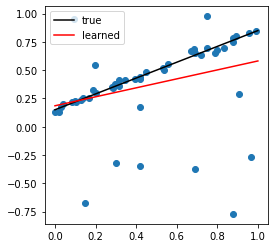

In [4]:
# Fit a linear regression, and the parameters of an adaptive loss with adaptive alpha.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu',scale_lo=1.0,alpha_hi=1.999,alpha_init=1.0,alpha_lo=0.001)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
loss_alpha=[]
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    loss_alpha.append(loss)
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression)
# alpha only work if scale is correctly learned
print(list(regression.parameters()))

0   : loss=1.392323  alpha=1.000000  scale=0.993690
100 : loss=0.659356  alpha=1.000000  scale=0.470275
200 : loss=0.229627  alpha=1.000000  scale=0.222498
300 : loss=0.176585  alpha=1.000000  scale=0.164762
400 : loss=0.176160  alpha=1.000000  scale=0.160376
500 : loss=0.176159  alpha=1.000000  scale=0.160298
600 : loss=0.176159  alpha=1.000000  scale=0.160298
700 : loss=0.176159  alpha=1.000000  scale=0.160298
800 : loss=0.176159  alpha=1.000000  scale=0.160298
900 : loss=0.176159  alpha=1.000000  scale=0.160298
1000: loss=0.176159  alpha=1.000000  scale=0.160298
1100: loss=0.176159  alpha=1.000000  scale=0.160298
1200: loss=0.176159  alpha=1.000000  scale=0.160298
1300: loss=0.176159  alpha=1.000000  scale=0.160298
1400: loss=0.176159  alpha=1.000000  scale=0.160298
1500: loss=0.176159  alpha=1.000000  scale=0.160298
1600: loss=0.176159  alpha=1.000000  scale=0.160298
1700: loss=0.176159  alpha=1.000000  scale=0.160298
1800: loss=0.176159  alpha=1.000000  scale=0.160298
1900: loss=0

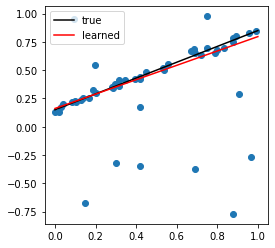

In [5]:
# Fit a linear regression, and the parameters of an adaptive loss with adaptive scale.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu',alpha_hi=1.0,alpha_lo=1.0)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
loss_scale=[]
for epoch in range(2000): 

    y_i = regression(x) 
    
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    loss_scale.append(loss)
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!

plot_regression(regression)
print(list(regression.parameters()))

0   : loss=1.652180  alpha=1.004995  scale=0.993690
100 : loss=0.597411  alpha=1.434313  scale=0.423810
200 : loss=0.281109  alpha=1.325829  scale=0.238186
300 : loss=0.071962  alpha=0.687807  scale=0.143869
400 : loss=-0.334337  alpha=0.224298  scale=0.056797
500 : loss=-0.616457  alpha=0.078488  scale=0.025207
600 : loss=-0.683239  alpha=0.039245  scale=0.018714
700 : loss=-0.701929  alpha=0.025147  scale=0.017271
800 : loss=-0.710409  alpha=0.018291  scale=0.016777
900 : loss=-0.715250  alpha=0.014267  scale=0.016537
1000: loss=-0.718377  alpha=0.011625  scale=0.016379
1100: loss=-0.720514  alpha=0.009762  scale=0.016289
1200: loss=-0.722157  alpha=0.008382  scale=0.016205
1300: loss=-0.721042  alpha=0.007321  scale=0.016152
1400: loss=-0.724338  alpha=0.006483  scale=0.016107
1500: loss=-0.725113  alpha=0.005805  scale=0.016074
1600: loss=-0.725744  alpha=0.005248  scale=0.016047
1700: loss=-0.726271  alpha=0.004783  scale=0.016023
1800: loss=-0.726687  alpha=0.004390  scale=0.0160

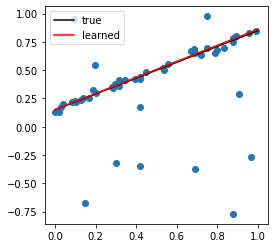

In [6]:
# Fit a linear regression, and the parameters of an adaptive loss with adaptive alpha and scale.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
loss_adaptive=[]
for epoch in range(2000): 

    y_i = regression(x) 
    

    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    loss_adaptive.append(loss)
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression)
print(list(regression.parameters()))